In [74]:
from cookie_clusters import *
import os
import cv2
from PIL import Image
import rasterio as rio
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
import pandas as pd
from tsfresh import extract_features
import numpy as np

In [2]:
# Select the pixels we wanna work with, for controled analyses
pixels_de_interet, dic_pix = create_dic_pixels()

In [3]:
# list of images
dir = "../../ressources/images"
images_list = os.listdir(dir)

# all images in a list, ready to be read
images_2A = list()
images_2B = list()
prog = re.compile(r'\w+2A')
for image in images_list:
    if prog.match(image):
        images_2A.append(image)
    else:
        images_2B.append(image)
        
images_2A.sort()
images_2B.sort()
all_images = images_2A + images_2B
all_images = sorted(all_images, key=lambda date: date[16:24])  

In [40]:
# Initiate lists for data frame
date = []
pixel_r = []
pixel_g = []
pixel_b = []
pixel_ir = []
pixel_ndvi = []
pixel_evi = []
x_coord = []
y_coord = []

# read each image --> select interesting pixels --> add to list
for temp, img in zip(range(len(all_images)), all_images):
    img = dir + "/" + img
    raster = rio.open(img)
    band_ir = raster.read(1)
    band_r = raster.read(2)
    band_g = raster.read(3)
    band_b = raster.read(4)
    band_ndvi = np.where((band_ir+band_r)==0, 0, (band_ir-band_r)/(band_ir+band_r))
    denominator = band_ir + 6 * band_r - 7.5 * band_b + 1
    denominator = np.where(denominator == 0, 1e-10, denominator)
    band_evi = 2.5 * (band_ir.astype(float) - band_r.astype(float)) / denominator

    for px_x, px_y in pixels_de_interet:
        ir = band_ir[px_x, px_y]
        r = band_r[px_x, px_y]
        g = band_g[px_x, px_y]
        b = band_b[px_x, px_y]
        ndvi = band_ndvi[px_x, px_y]
        evi = band_evi[px_x, px_y]
        
        date.append(temp)
        x_coord.append(px_x)
        y_coord.append(px_y)
        pixel_ir.append(ir)
        pixel_r.append(r)
        pixel_g.append(g)
        pixel_b.append(b)
        pixel_ndvi.append(ndvi)
        pixel_evi.append(evi)

/tmp/ipykernel_10158/472414207.py:20: RuntimeWarning: invalid value encountered in divide
  band_ndvi = np.where((band_ir+band_r)==0, 0, (band_ir-band_r)/(band_ir+band_r))


In [41]:
# the final DF has the values of pixels of interest for all the chanels and for all period of time
dic = {'date': date,
       'x_coord': x_coord,
       'y_coord': y_coord,
       'pixel_ir': pixel_ir,
       'pixel_r': pixel_r,
       'pixel_g': pixel_g,
       'pixel_b': pixel_b,
       'pixel_ndvi': pixel_ndvi,
       'pixel_evi': pixel_evi}

df = pd.DataFrame(dic)

In [56]:
df_transforme = df.copy()
df_transforme['id'] = df_transforme['x_coord'].astype(str) + df_transforme['y_coord'].astype(str)

df_transforme = df_transforme.loc[:, ~df_transforme.columns.isin(['x_coord', 'y_coord', 'pixel_evi'])]

df_transforme

,date,pixel_ir,pixel_r,pixel_g,pixel_b,pixel_ndvi,id
0,0,1287,315,303,232,0.606742,472570
1,0,1045,302,263,222,0.551596,474570
2,0,843,228,256,205,0.574230,476570
3,0,1150,321,279,237,0.563562,478570
4,0,1234,345,304,224,0.563015,480570
...,...,...,...,...,...,...,...
7609,140,3119,3328,3012,2455,-0.032418,387505
7610,140,3526,3875,3451,2918,-0.047156,384508
7611,140,3990,3950,3895,3300,0.005038,388509
7612,140,3530,3622,3368,2956,-0.012864,384504


In [57]:
extracted_features = extract_features(df_transforme, column_id="id", column_sort="date")

Feature Extraction: 100%|██████████| 30/30 [00:03<00:00,  9.52it/s]


In [58]:
print(extracted_features.shape)
extracted_features.head()

(54, 3915)


,pixel_g__variance_larger_than_standard_deviation,pixel_g__has_duplicate_max,pixel_g__has_duplicate_min,pixel_g__has_duplicate,pixel_g__sum_values,pixel_g__abs_energy,pixel_g__mean_abs_change,pixel_g__mean_change,pixel_g__mean_second_derivative_central,pixel_g__median,...,pixel_r__fourier_entropy__bins_5,pixel_r__fourier_entropy__bins_10,pixel_r__fourier_entropy__bins_100,pixel_r__permutation_entropy__dimension_3__tau_1,pixel_r__permutation_entropy__dimension_4__tau_1,pixel_r__permutation_entropy__dimension_5__tau_1,pixel_r__permutation_entropy__dimension_6__tau_1,pixel_r__permutation_entropy__dimension_7__tau_1,pixel_r__query_similarity_count__query_None__threshold_0.0,pixel_r__mean_n_absolute_max__number_of_maxima_7
318438,1.0,0.0,0.0,1.0,136279.0,-22365.0,344.100000,4.500000,0.949640,830.0,...,0.473037,0.520432,2.236538,1.738038,2.917743,3.941998,4.614350,4.823124,NaN,3712.428571
322435,1.0,0.0,0.0,1.0,137386.0,-28266.0,351.164286,4.807143,0.697842,831.0,...,0.473037,0.592758,2.245780,1.724726,2.887003,3.901017,4.571078,4.812855,NaN,3790.285714
324433,1.0,0.0,0.0,1.0,138935.0,23563.0,358.221429,5.635714,1.064748,831.0,...,0.473037,0.645332,2.338705,1.729248,2.906701,3.900483,4.535633,4.720436,NaN,3865.428571
329429,1.0,0.0,0.0,1.0,136669.0,-26399.0,349.957143,6.128571,1.546763,835.0,...,0.435726,0.592758,2.310277,1.747002,2.956407,4.020586,4.632238,4.833393,NaN,3819.714286
333426,1.0,0.0,0.0,1.0,137242.0,-6652.0,351.407143,6.735714,1.625899,836.0,...,0.435726,0.592758,2.055184,1.752320,2.995927,4.069351,4.670513,4.874468,NaN,3856.714286


In [59]:
extrac_features_NOna = extracted_features.dropna(axis=1)
print(extrac_features_NOna.shape)
extrac_features_NOna.head()

(54, 3307)


,pixel_g__variance_larger_than_standard_deviation,pixel_g__has_duplicate_max,pixel_g__has_duplicate_min,pixel_g__has_duplicate,pixel_g__sum_values,pixel_g__abs_energy,pixel_g__mean_abs_change,pixel_g__mean_change,pixel_g__mean_second_derivative_central,pixel_g__median,...,pixel_r__fourier_entropy__bins_3,pixel_r__fourier_entropy__bins_5,pixel_r__fourier_entropy__bins_10,pixel_r__fourier_entropy__bins_100,pixel_r__permutation_entropy__dimension_3__tau_1,pixel_r__permutation_entropy__dimension_4__tau_1,pixel_r__permutation_entropy__dimension_5__tau_1,pixel_r__permutation_entropy__dimension_6__tau_1,pixel_r__permutation_entropy__dimension_7__tau_1,pixel_r__mean_n_absolute_max__number_of_maxima_7
318438,1.0,0.0,0.0,1.0,136279.0,-22365.0,344.100000,4.500000,0.949640,830.0,...,0.289970,0.473037,0.520432,2.236538,1.738038,2.917743,3.941998,4.614350,4.823124,3712.428571
322435,1.0,0.0,0.0,1.0,137386.0,-28266.0,351.164286,4.807143,0.697842,831.0,...,0.343431,0.473037,0.592758,2.245780,1.724726,2.887003,3.901017,4.571078,4.812855,3790.285714
324433,1.0,0.0,0.0,1.0,138935.0,23563.0,358.221429,5.635714,1.064748,831.0,...,0.302126,0.473037,0.645332,2.338705,1.729248,2.906701,3.900483,4.535633,4.720436,3865.428571
329429,1.0,0.0,0.0,1.0,136669.0,-26399.0,349.957143,6.128571,1.546763,835.0,...,0.343431,0.435726,0.592758,2.310277,1.747002,2.956407,4.020586,4.632238,4.833393,3819.714286
333426,1.0,0.0,0.0,1.0,137242.0,-6652.0,351.407143,6.735714,1.625899,836.0,...,0.201936,0.435726,0.592758,2.055184,1.752320,2.995927,4.069351,4.670513,4.874468,3856.714286


In [60]:
km = KMeans(n_clusters=6)
classes = km.fit_predict(extrac_features_NOna)
classes

/home/afonso/miniconda3/envs/filRouge/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 4, 4, 4, 1, 5, 4, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [61]:
km_results = pd.DataFrame({'index': extrac_features_NOna.index, 'cluster': classes})
km_results.head()

,index,cluster
0,318438,3
1,322435,3
2,324433,3
3,329429,3
4,333426,3


In [62]:
pix_id = {'pix_foret': [str(sublista[0])+str(sublista[1]) for sublista in dic_pix['pix_foret']],
          'pix_danone': [str(sublista[0])+str(sublista[1]) for sublista in dic_pix['pix_danone']],
          'pix_agri': [str(sublista[0])+str(sublista[1]) for sublista in dic_pix['pix_agri']],
          'pix_ensta': [str(sublista[0])+str(sublista[1]) for sublista in dic_pix['pix_ensta']],
          'pix_apt': [str(sublista[0])+str(sublista[1]) for sublista in dic_pix['pix_apt']],
          'pix_lac': [str(sublista[0])+str(sublista[1]) for sublista in dic_pix['pix_lac']]}

In [63]:
lista = []
for row in km_results.iterrows():
    for pix in pix_id.keys():
        if row[1][0] in pix_id[pix]:
            lista.append(pix)

km_results['lieu'] = lista
km_results

,index,cluster,lieu
0,318438,3,pix_agri
1,322435,3,pix_agri
2,324433,3,pix_agri
3,329429,3,pix_agri
4,333426,3,pix_agri
5,337424,3,pix_agri
6,339422,3,pix_agri
7,344418,3,pix_agri
8,350414,3,pix_agri
9,383497,0,pix_danone


In [64]:
pix_list = []
for index in list(km_results['index']):
    pix_list.append([int(index[0:3]), int(index[3:])])

# Evaluate KMEANS clustering - with cookie_cluster

In [69]:
evaluate = evaluator_de_experiences(classes, pix_list, dic_pix, extrac_features_NOna)

In [70]:
evaluate.show_list()

cluster numero 0:
-------------------------------
[383, 497] : pix_danone
[383, 500] : pix_danone
[383, 504] : pix_danone
[384, 504] : pix_danone
[384, 508] : pix_danone
[386, 504] : pix_danone
[387, 501] : pix_danone
[387, 505] : pix_danone
[388, 509] : pix_danone
[388, 532] : pix_lac
[392, 567] : pix_lac
[392, 580] : pix_lac
[394, 598] : pix_lac
[395, 570] : pix_lac
[395, 576] : pix_lac
[397, 571] : pix_lac
[401, 567] : pix_lac
[401, 577] : pix_lac
[414, 440] : pix_apt
[433, 617] : pix_ensta
[439, 629] : pix_ensta
[443, 636] : pix_ensta
[447, 618] : pix_ensta
[450, 641] : pix_ensta
[454, 627] : pix_ensta
[454, 631] : pix_ensta
[457, 632] : pix_ensta
[459, 625] : pix_ensta
-------------------------------
cluster numero 1:
-------------------------------
[408, 444] : pix_apt
-------------------------------
cluster numero 2:
-------------------------------
[472, 570] : pix_foret
[474, 570] : pix_foret
[476, 570] : pix_foret
[478, 570] : pix_foret
[480, 570] : pix_foret
[482, 570] : pix_

In [72]:
evaluate.metrics_clustering()

,calinski_harabasz_score
0,93.523143


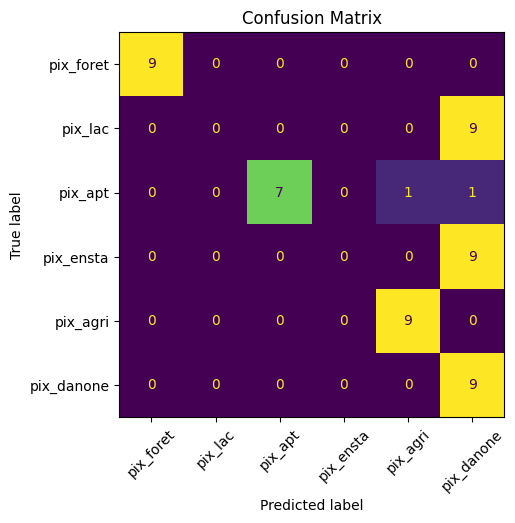

In [71]:
evaluate.confusion_matrix()

# evaluate DBSCAN

In [91]:
dbscan = DBSCAN(eps=1e7, min_samples=5)
classes_db = dbscan.fit_predict(extrac_features_NOna)
classes_db

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1, -1, -1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1])

In [92]:
evaluate_db = evaluator_de_experiences(classes_db, pix_list, dic_pix, extrac_features_NOna)

In [93]:
evaluate_db.metrics_clustering()

,calinski_harabasz_score
0,26.068283


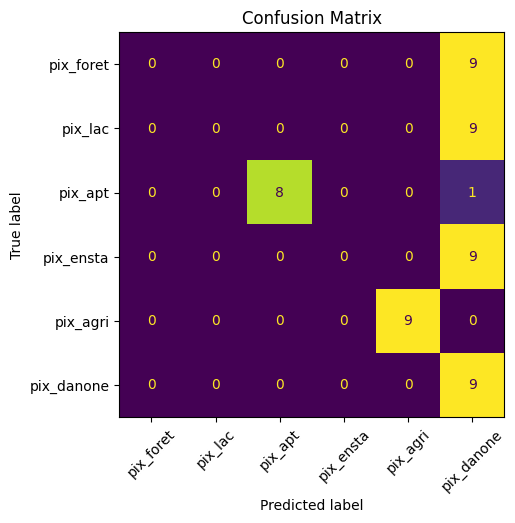

In [94]:
evaluate_db.confusion_matrix()

# evaluate OPTICS

In [132]:
optics = OPTICS(min_samples=4)
classes_op = optics.fit_predict(extrac_features_NOna)
classes_op

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  1, -1,  1, -1,  1, -1,
       -1,  2,  2,  2,  2,  2,  2,  2, -1,  2,  2, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  3,  3,  3,  3,  3,
        3, -1,  3])

In [133]:
evaluate_op = evaluator_de_experiences(classes_op, pix_list, dic_pix, extrac_features_NOna)

In [134]:
evaluate_op.show_list()

cluster numero 0:
-------------------------------
[318, 438] : pix_agri
[322, 435] : pix_agri
[324, 433] : pix_agri
[329, 429] : pix_agri
[333, 426] : pix_agri
[337, 424] : pix_agri
[339, 422] : pix_agri
[344, 418] : pix_agri
[350, 414] : pix_agri
-------------------------------
cluster numero 1:
-------------------------------
[383, 500] : pix_danone
[383, 504] : pix_danone
[384, 508] : pix_danone
[387, 501] : pix_danone
[454, 627] : pix_ensta
-------------------------------
cluster numero 2:
-------------------------------
[388, 532] : pix_lac
[392, 567] : pix_lac
[392, 580] : pix_lac
[394, 598] : pix_lac
[395, 570] : pix_lac
[395, 576] : pix_lac
[397, 571] : pix_lac
[401, 567] : pix_lac
[401, 577] : pix_lac
-------------------------------
cluster numero 3:
-------------------------------
[474, 570] : pix_foret
[476, 570] : pix_foret
[478, 570] : pix_foret
[480, 570] : pix_foret
[482, 570] : pix_foret
[484, 570] : pix_foret
[488, 570] : pix_foret
-------------------------------
clust

In [135]:
evaluate_op.metrics_clustering()

,calinski_harabasz_score
0,6.255694


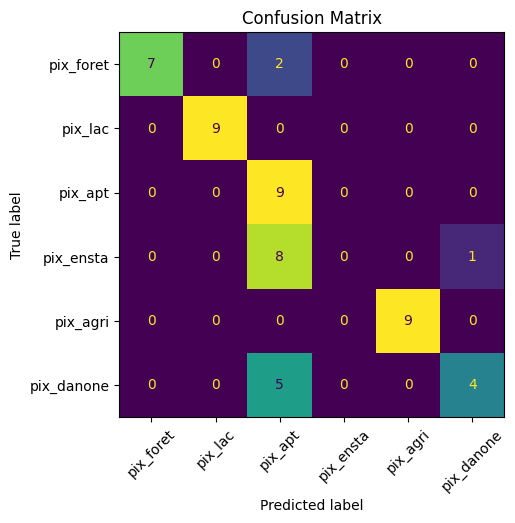

In [136]:
evaluate_op.confusion_matrix()

# evaluate CAH

In [100]:
cah = AgglomerativeClustering(n_clusters=6)
classes_cah = cah.fit_predict(extrac_features_NOna)
classes_cah

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 0, 3, 3, 0, 4, 0, 5, 1, 4, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [101]:
evaluate_cah = evaluator_de_experiences(classes_cah, pix_list, dic_pix, extrac_features_NOna)

In [102]:
evaluate_cah.metrics_clustering()

,calinski_harabasz_score
0,92.815793


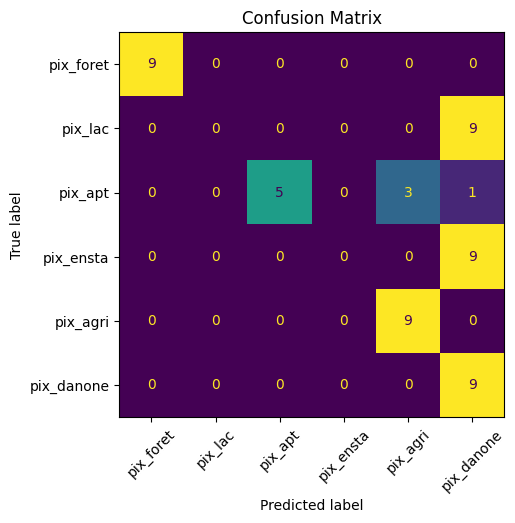

In [103]:
evaluate_cah.confusion_matrix()

# Trying an ACP in order to get rid of inutile attributs

In [ ]:
from sklearn.decomposition import PCA


pca = PCA(n_components=0.99)
pca.fit(extrac_features_NOna)
X_pca = pca.transform(extrac_features_NOna)

In [ ]:
np.cumsum(pca.explained_variance_ratio_*100)

In [ ]:
km = KMeans(n_clusters=6)
classes = km.fit_predict(extrac_features_NOna)
classes

km_results = pd.DataFrame({'index': extrac_features_NOna.index, 'cluster': classes})
km_results.head()

test = [str(sublista[0])+str(sublista[1]) for sublista in pix_foret]

pix_id = {'pix_foret': [str(sublista[0])+str(sublista[1]) for sublista in pix_foret],
          'pix_danone': [str(sublista[0])+str(sublista[1]) for sublista in pix_danone],
          'pix_agri': [str(sublista[0])+str(sublista[1]) for sublista in pix_agri],
          'pix_ensta': [str(sublista[0])+str(sublista[1]) for sublista in pix_ensta],
          'pix_apt': [str(sublista[0])+str(sublista[1]) for sublista in pix_apt],
          'pix_lac': [str(sublista[0])+str(sublista[1]) for sublista in pix_lac]}

lista = []
for row in km_results.iterrows():
    for pix in pix_id.keys():
        if row[1][0] in pix_id[pix]:
            lista.append(pix)

km_results['lieu'] = lista
km_results